# Install PyCUDA

In [3]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.2 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2023.1-cp310-cp310-linux_x86_64.whl size=661263 sha256=dcca61cedcc6d31669e089631d4b045de9e9e332311b62e5435898fd695f78db
  Stored in directory: /root/.cache/pip/wheels/46/65/06/b997165edd2fd9690c3497ca54ea4485b571d7bd959c21c6c4
Successfully built pycuda


# Import libs and launch test code

In [4]:
import pycuda.autoinit
import pycuda.driver as cuda
import numpy as np
from pycuda.compiler import SourceModule
import time


In [5]:
mod = SourceModule("""
__global__ void multiply_them(float *dest, float *a, float *b)
{
  const int i = threadIdx.x;
  dest[i] = a[i] * b[i];
}
""")

a = np.random.randn(400).astype(np.float32)
b = np.random.randn(400).astype(np.float32)

# Allocate memory on the device
a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)
dest_gpu = cuda.mem_alloc(a.nbytes)

# Copy data from host to device
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

# Execute the kernel
func = mod.get_function("multiply_them")
func(dest_gpu, a_gpu, b_gpu, block=(400,1,1))

# Copy result from device to host
dest = np.empty_like(a)
cuda.memcpy_dtoh(dest, dest_gpu)

# Display results
print(dest)


[-2.26424277e-01  9.23526660e-02 -2.23285246e+00 -9.84963834e-01
 -6.84640929e-03  2.31880382e-01 -5.49732208e-01 -1.28130417e-03
 -4.68925480e-03  1.19952090e-01 -1.56040549e+00 -3.55601102e-01
 -5.91657460e-01 -3.10002477e-03  8.34629238e-01 -9.56358295e-03
  1.91869706e-01 -7.59937242e-02  7.11655915e-01  2.88383186e-01
 -1.10345435e+00 -7.54317939e-01 -6.01147056e-01 -1.25891018e+00
 -1.37061691e+00  4.95328665e-01 -3.76414239e-01 -1.87324989e+00
  3.04182824e-02 -6.56089559e-02  4.37301219e-01 -1.04530454e-02
  1.58662367e+00  6.19619310e-01  1.23594880e-01  2.63085961e-01
 -1.69784796e+00 -7.45905519e-01 -5.59500515e-01 -5.71919233e-02
  9.36778903e-01  7.64561072e-02 -5.03914714e-01 -5.73247783e-02
 -1.05656922e-01  1.69001043e-01 -2.22430363e-01  5.91928065e-01
  3.84031475e-01 -3.72728050e-01 -9.89237428e-01  1.12123210e-02
  1.24178067e-01 -1.76814032e+00  2.66046166e+00 -1.24413395e+00
 -2.08585548e+00 -6.73705190e-02 -2.32674573e-02 -5.39887277e-03
 -2.22677779e+00 -6.36083

# Mandelbrot set: CUDA version

In [6]:
mod = SourceModule("""
__device__ int mandelbrot(float real, float imag, int max_iter) {
    float r = real;
    float i = imag;
    for (int t = 0; t < max_iter; t++) {
        if (r * r + i * i > 4.0) return t;
        float new_r = r * r - i * i + real;
        i = 2 * r * i + imag;  // TODO: change 0 to correct code
        r = new_r;
    }
    return 0;
}


__global__ void compute_mandelbrot(float *output, int width, int height, float x_min, float x_max, float y_min, float y_max, int max_iter) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int idy = blockIdx.y * blockDim.y + threadIdx.y;
    if (idx < width && idy < height) {
        float real = x_min + idx * (x_max - x_min) / width;
        float imag = y_min + idy * (y_max - y_min) / height;  // TODO: change 0 to correct code
        output[idy * width + idx] = mandelbrot(real, imag, max_iter);
    }
}
""")

def cuda_mandelbrot(width, height, x_min, x_max, y_min, y_max, max_iter):
    output = np.zeros((height, width), dtype=np.float32)

    # Allocate memory on the device
    output_gpu = cuda.mem_alloc(output.nbytes)

    # Execute the kernel
    block_size = (16, 16, 1)
    grid_size = (width // block_size[0] + 1, height // block_size[1] + 1)

    start = time.time()
    func = mod.get_function("compute_mandelbrot")
    func(output_gpu, np.int32(width), np.int32(height), np.float32(x_min), np.float32(x_max), np.float32(y_min), np.float32(y_max), np.int32(max_iter), block=block_size, grid=grid_size)
    cuda.Context.synchronize()  # Wait for the computation to finish
    end = time.time()

    # Copy the result back to the host
    cuda.memcpy_dtoh(output, output_gpu)

    return output, end - start

width, height = 1024, 768
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5
max_iter = 128

mandelbrot_image, time_cuda = cuda_mandelbrot(width, height, x_min, x_max, y_min, y_max, max_iter)
print("CUDA Time:", time_cuda)


CUDA Time: 0.0002536773681640625


# Mandelbrot set: Numpy (cpu) version

In [7]:
def numpy_mandelbrot(width, height, x_min, x_max, y_min, y_max, max_iter):
    output = np.zeros((height, width), dtype=np.float32)
    for y in range(height):
        imag = y_min + y * (y_max - y_min) / height
        for x in range(width):
            real = x_min + x * (x_max - x_min) / width  # TODO: change 0 to correct code
            r, i = real, imag
            for t in range(max_iter):
                if r * r + i * i > 4.0:
                    output[y, x] = t
                    break
                r = r * r - i * i + real # TODO: change 0 to correct code
                i = 2 * r * i + imag

    return output

start = time.time()
mandelbrot_image_numpy = numpy_mandelbrot(width, height, x_min, x_max, y_min, y_max, max_iter)
end = time.time()
time_numpy = end - start
print("CPU Time:", time_numpy)


CPU Time: 9.352971076965332


# Validate results

Text(0.5, 1.0, 'Numpy. Time: 6.828242301940918')

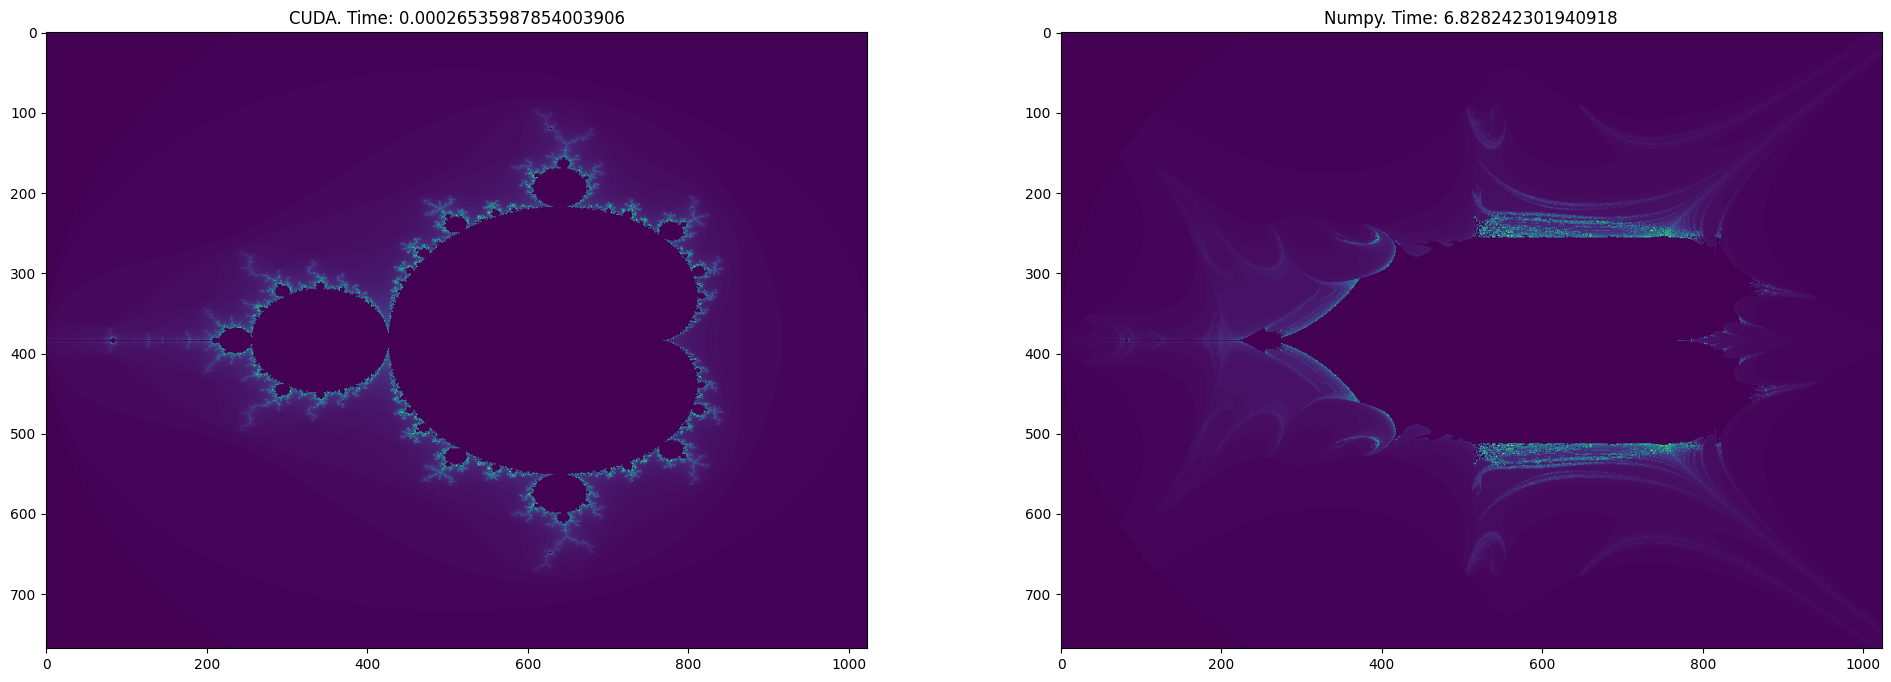

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(24, 8))
axs[0].imshow(mandelbrot_image)
axs[0].set_title(f"CUDA. Time: {time_cuda}")
axs[1].imshow(mandelbrot_image_numpy)
axs[1].set_title(f"Numpy. Time: {time_numpy}")
